<a href="https://colab.research.google.com/github/sestys/aicrowd_blitz4/blob/main/smeel_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a quick guide exploring what CNNs can do with an image representation of molecules

Covered in this guide:

1- Downloading and using rdkit <br>
2- Visualizing molecules using rdkit <br>
3- Using a pretrained inception_v3 model <br>
4- making predictions and submission file <br>

We first download the data:

In [ ]:
!gdown --id 1t5be8KLHOz3YuSmiiPQjopb4c_q2U4tG

Downloading...
From: https://drive.google.com/uc?id=1t5be8KLHOz3YuSmiiPQjopb4c_q2U4tG
To: /content/olfactorydata.zip
100% 94.3k/94.3k [00:00<00:00, 42.7MB/s]


In [ ]:
!unzip olfactorydata.zip 

Archive:  olfactorydata.zip
  inflating: train.csv               
  inflating: test.csv                
  inflating: sample_submission.csv   
  inflating: vocabulary.txt          


In [ ]:
!ls

olfactorydata.zip  sample_submission.csv  train.csv
sample_data	   test.csv		  vocabulary.txt


Next we install rdkit:

**Credits to**: https://stackoverflow.com/questions/63152656/installing-rdkit-in-google-colab

In [ ]:
!wget -q -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -q -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
vocabulary = open("vocabulary.txt").read()

Convert smiles to rdkit Mol objects

In [ ]:
mols = [Chem.MolFromSmiles(smile) for smile in train.SMILES]
mols_test = [Chem.MolFromSmiles(smile) for smile in test.SMILES]

Let's have a look at the data:

In [ ]:
img = Draw.MolsToGridImage(mols[:8],molsPerRow=4,subImgSize=(256,256), legends=train.SENTENCE.tolist()[:8])

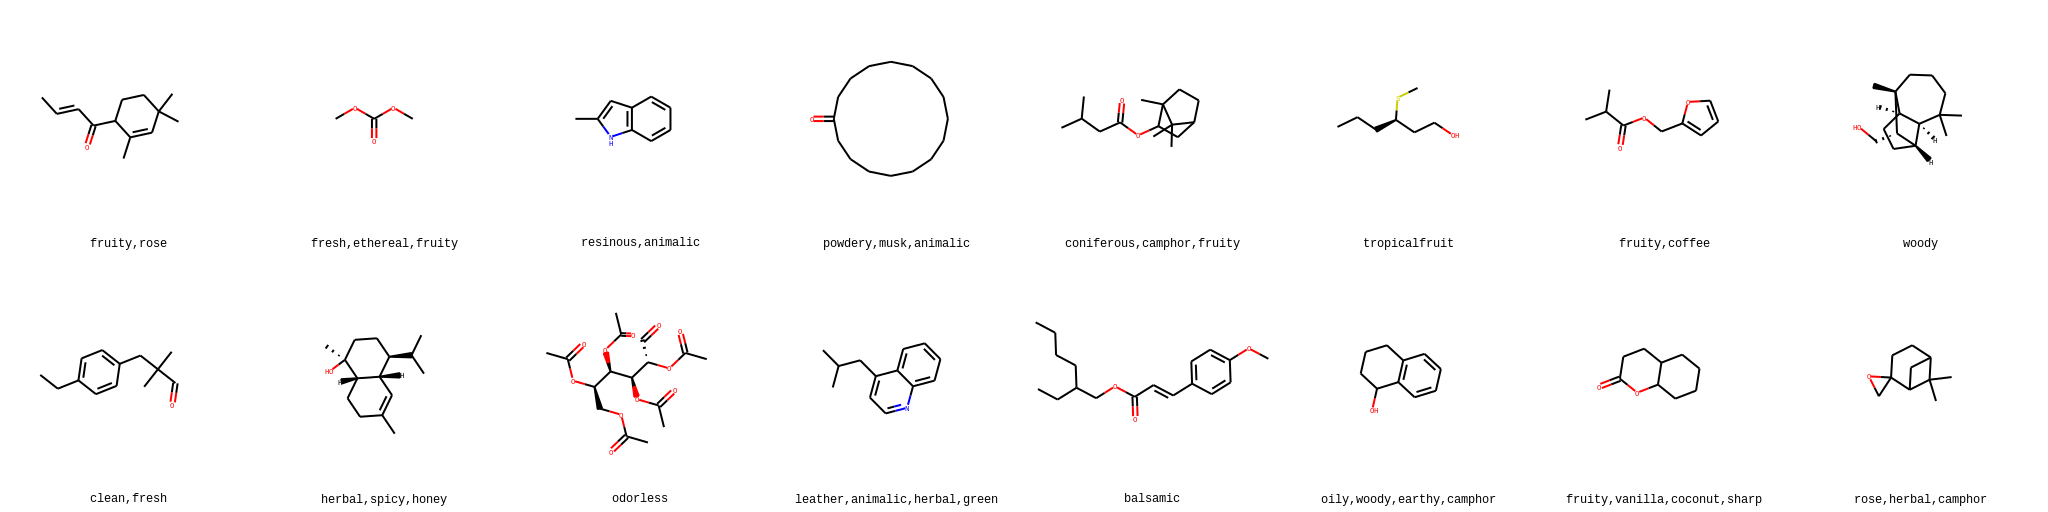

In [ ]:
img

Saving the data as images:

In [ ]:
!mkdir imgs
!mkdir imgs_test

In [ ]:
for i in range(len(mols)):
  Draw.MolToFile(mols[i], "imgs/{}.png".format(i), size=(256,256), imageType="png")
for i in range(len(mols_test)):
  Draw.MolToFile(mols_test[i], "imgs_test/{}.png".format(i), size=(256,256), imageType="png")

Representing vocabulary as a one-hot vector:

In [ ]:
vocabulary = vocabulary.split('\n')

In [ ]:
def oneHotSentence(sentence):
  l = np.zeros(len(vocabulary))
  for label in sentence.split(','):
    l[vocabulary.index(label)] = 1
  return l

In [ ]:
y = np.zeros((train.shape[0], len(vocabulary)), dtype=np.float32)

In [ ]:
for i in range(train.shape[0]):
  y[i] = oneHotSentence(train.SENTENCE.iloc[i])

Dataset and train pipeline: <br>
**Credits to**: https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72

In [ ]:
IMG_SIZE = 256 
CHANNELS = 3 
def parse_function(filename, label):
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = tf.cast(image_decoded, tf.float32) / 255.0
    return image_normalized, label


In [ ]:
import tensorflow as tf
tf.random.set_seed(0)

BATCH_SIZE = 64 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
def create_dataset(filenames, labels, is_training=True):
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset


In [ ]:
filenames = np.array(["imgs/{}.png".format(i) for i in range(train.shape[0])])

Split train and validation sets:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(filenames, y, test_size=0.1, random_state=0)

In [ ]:
train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)

Use Tensorflow Hub to get pretrained inception_v3 model:

In [ ]:
import tensorflow_hub as hub

feature_extractor_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(len(vocabulary), activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              2098176   
_________________________________________________________________
output (Dense)               (None, 109)               111725    
Total params: 24,012,685
Trainable params: 2,209,901
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
LR = 1e-5 
EPOCHS = 8
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=BinaryCrossentropy(),
  metrics=["accuracy"])

Start Training:

In [ ]:
from time import time
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/8
61/61 [==============================] - 31s 501ms/step - loss: 0.5745 - accuracy: 0.0062 - val_loss: 0.4217 - val_accuracy: 0.0116
Epoch 2/8
61/61 [==============================] - 26s 425ms/step - loss: 0.3125 - accuracy: 0.0142 - val_loss: 0.2195 - val_accuracy: 0.0116
Epoch 3/8
61/61 [==============================] - 26s 428ms/step - loss: 0.1772 - accuracy: 0.0260 - val_loss: 0.1449 - val_accuracy: 0.0463
Epoch 4/8
61/61 [==============================] - 26s 427ms/step - loss: 0.1343 - accuracy: 0.0631 - val_loss: 0.1231 - val_accuracy: 0.0625
Epoch 5/8
61/61 [==============================] - 26s 427ms/step - loss: 0.1210 - accuracy: 0.0693 - val_loss: 0.1156 - val_accuracy: 0.0602
Epoch 6/8
61/61 [==============================] - 26s 425ms/step - loss: 0.1160 - accuracy: 0.0711 - val_loss: 0.1123 - val_accuracy: 0.0602
Epoch 7/8
61/61 [==============================] - 26s 423ms/step - loss: 0.1136 - accuracy: 0.0754 - val_loss: 0.1106 - val_accuracy: 0.0625
Epoch 

In [ ]:
val_preds = model.predict(val_ds)

Let's sanity check some outputs:

In [ ]:
ind = 64

In [ ]:
for i in np.argpartition(val_preds[ind], -4)[-4:]: #This gets the indices of top four predictions
  print(vocabulary[i])

floral
herbal
fruity
woody


In [ ]:
filename = X_val[ind]
train.SENTENCE.iloc[int(filename[5:-4])]

'oily,fruity'

Looks like the model is overfitting; let's submit predictions anyway.

Now load the test set and make predictions:

In [ ]:
filenames_test = ["imgs_test/{}.png".format(i) for i in range(test.shape[0])]
imgs_test = np.zeros((len(filenames_test), 256,256,3))
i = 0
for filename in filenames_test:
  imgs_test[i] = parse_function(filename,0)[0]
  i += 1

In [ ]:
preds_test = model.predict(imgs_test)

In this part we take the top 15 predictions and convert them to sentence format for submission:

In [ ]:
predictions = []
for i in range(preds_test.shape[0]):
  top_15 = np.argpartition(preds_test[i], -15)[-15:] #Get indices of top 15 predictions
  top_15_voc = [vocabulary[i] for i in top_15] #Get words from those indices
  pred_string = ""
  for i in range(0,15,3):
    pred_string += ','.join(top_15_voc[i:i+3]) + ';'
  predictions.append(pred_string[:-1]) 

In [ ]:
sample_submission.PREDICTIONS = predictions

In [ ]:
sample_submission.to_csv("CNN_submission.csv",index=None)

This was a simple guide exploring CNNs in the context of this competition and getting started with a simple pipeline.<br>If you have suggestions/improvements I'm all ears.